# Katya's Project 4 

In this project I analysed Data Science jobs advertised on www.indeed.com. I scraped around 40K data science ads from the site and split them into bins by salary: 
- 'junior' - salary range 55-70K
- 'middle-low' - salary range 70-85K
- 'middle-high' - salary range 85-100K 
- 'senior' - salary range 100-115K

Then by means of Natural Language Processing Python library I did analysed (tokenized) all the words and found those ones which could be used as a markers for the corresponding salary bins.

Then I built Logistic Regression model which allows determining probable salary range. This might be helpful for job seekers to assess any particular Data Science job description and forecast the salary offered by company or match their expectations with the current Data Science Labour market tendency.


Outline:

* scraping data: I scraped 39959 positions from www.indeed.com in equal proportion for each bin. So we can assume that the data set is balanced. 

* binning: by salary

* cleaning data: I removed all the stopwords(commas, zero-meaning words, etc.)

* parsing data: tokenizing, finding bigrams, most_common words for each bin 

* building model

* evaluating model


# Scraping data from the Web

Importing all the libraries

In [3]:
import matplotlib as plt
%matplotlib inline
import pandas as pd
from bs4 import BeautifulSoup
import urllib2, requests

Next step - setup a request (using 'requests') to the URL (in the next step below). BeautifulSoup was used to parse the page and extract all results. There are 4 functions to extract each item: location, company, job title, salary and summary.

In [3]:
def extract_text(el):
    if el:
        return el.text.strip()
    else:
        return ''      

def get_company_from_result(result):
    return extract_text(result.find('span', {'class' : 'company'}))

def get_location_from_result(result):
    return extract_text(result.find('span', {'class' : 'location'}))

def get_summary_from_result(result):
    return extract_text(result.find('span', {'class' : 'summary'}))

def get_title_from_result(result):
    return result.find('a', {'data-tn-element' : 'jobTitle'}).text.strip()

def get_salary_from_result(result):
    salary_table = result.find('td', {'class' : 'snip'})
    if salary_table:
        snip = salary_table.find('nobr')
        if snip:
            return snip.text.strip()

    return None


def extract_salary_average(salary_string):
    regex = r'\$([0-9]+,[0-9]+)'
    matches = re.findall(regex, salary_string)
    return np.mean([float(salary.replace(',', '')) for salary in matches ])


It is appeared that companies rarely show salary in adds. So, I created set of salary bins in thousand US.Dollars ( '55-70', '70-85', '85-100', '100-115') and included it into URL in order to do scraping by bins:

In [74]:

url_template = "http://www.indeed.com/jobs?q=data+scientist+${}%2C000&l=USA&start={}"
max_results_per_city = 5000 # Set this to a high-value (5000) to generate more results. 

# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

#city = elem.find('span', attrs={'itemprop':'addressLocality'}).getText()

rows = []
for salary in set([ '55-70', '70-85', '85-100', '100-115']):
    for start in range(1,10): 
        r = requests.get(url_template.format(salary, start))
        soup = BeautifulSoup(r.content) 
        results = soup.findAll('div', { "class" : "result" })
        for result in results:
            if result:
                row = {}
                row['title'] = get_title_from_result(result)
                row['company'] = get_company_from_result(result)
                row['summary'] = get_summary_from_result(result)
                row['city'] = get_location_from_result(result) 
                row['bin'] = salary
            #row['salary'] = get_salary_from_result(result)
                rows.append(row)
                

Now the scraped data set can be written on disc for time-saving reasons. It can be renewed if it is needed any time.

In [5]:
result.to_csv('./indeed_companies.csv', encoding='utf-8')

To check bins, for example lets have a look at the firs one (55-70). It contains 9990 positions (out of 39959) so it is one fourth:

In [32]:
pd.set_option('max_colwidth',500)
df = pd.read_csv('indeed_companies.csv')
df[df.bin =="55-70"]

,Unnamed: 0,bin,city,company,summary,title
29970,29970,55-70,"Rockville, MD",ICF,"Experience analyzing data from large social surveys.*. We are business analysts, policy specialists, technologists, researchers, digital strategists, social...",Data Analyst
29971,29971,55-70,"Wellesley, MA 02481",Aetna,"The Data Scientist will develop, implement and measure the impact of solutions spanning all available touch points with health care consumers....",Data Scientist Statistician
29972,29972,55-70,"Newton, MA","Thermalin Diabetes, LLC",Knack for communicating stories through data visualizations. Format and analyze data to extract key performance parameters....,"Data Scientist - Newton, MA (will work in Boston, MA area)"
29973,29973,55-70,"Framingham, MA",Staples,: Qualifications Job : Location(s) : Other Locations : Schedule : : : ...,"Data Scientist, Framingham, MA"
29974,29974,55-70,"Hartford, CT 06156",Aetna,"Ability to work with large data sets from multiple data sources.· Demonstrates proficiency in several areas of data modeling, machine learning algorithms,...",Data Scientist Analyst
29975,29975,55-70,"Cambridge, MA",KAYAK.com,"Investigate data problems, identify patterns. This person should love working on data parsing, analyzing, investigating, interpreting, modeling, and extracting...",Data Scientist
29976,29976,55-70,"Springfield, VA",Concurrent Technologies Corporation,"Associate Data Scientist. CTC has an opportunity for a qualified Associate Data Scientist at Springfield, VA. Responsibilities include preparing thorough, well...",Associate Data Scientist
29977,29977,55-70,"Raleigh, NC","Resolvit, LLC","Technical knowledge regarding data models, database design development, data mining, and segmentation techniques....",Data Scientist
29978,29978,55-70,"Cambridge, MA",Massachusetts General Hospital(MGH),"In addition, this position involves data analysis and preparation of academic manuscripts and figures as well as abstracts to attend to scientific conferences....","Research Scientist, Sr. (Phd)"
29979,29979,55-70,"Alpharetta, GA",krg technology inc,Data scientist with either a Masters or PhD. Should know Machine learning....,Data Scientist


Let's check contain of the other bins:

In [6]:
df.bin.value_counts()

85-100     9990
55-70      9990
100-115    9990
70-85      9990
Name: bin, dtype: int64

# Cleaning Data

Importing all the libraries:

In [18]:
import nltk
import nltk.stem
import nltk.stem.porter
import nltk.stem.snowball
snowball = nltk.stem.snowball.SnowballStemmer("english")
from nltk.corpus import stopwords
import re
from nltk.probability import FreqDist

Subsetting data from DataFrame over categories(bins), converting into strings and assigning to new variables for the each bin.

In [9]:
junior = str(df[df['bin'].isin(['55-70'])].summary) 
mid_low = str(df[df['bin'].isin(['70-85'])].summary)
mid_high = str(df[df['bin'].isin(['85-100'])].summary)
senior = str(df[df['bin'].isin(['100-115'])].summary)

Removing all the upper-case characters

In [37]:
junior = junior.lower()
mid_low = mid_low.lower()
mid_high = mid_high.lower()
senior = senior.lower()

Cleaning it from numbers, characters, stopwords. Stopwords are meaningless words such as 'the', 'is', 'he', 'she', etc. I also updated the stopwords because in our case 'data' and 'scientist' words are not so meaningful as well 

In [54]:
junior_clean = re.sub("[^a-zA-Z]", " ", junior)
mid_low_clean = re.sub("[^a-zA-Z]", " ", mid_low)
mid_high_clean = re.sub("[^a-zA-Z]", " ", mid_high)
senior_clean = re.sub("[^a-zA-Z]", " ", senior)

stop = set(stopwords.words('english'))
stop.update([',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '...', 'Data', 'data', 'scientist', 'Scientist', 'ii', 'abc'])

NExt step - tokenizing using fancy NLTK library and removing stopwords

In [55]:
junior_words = [w for w in (nltk.word_tokenize(junior_clean)) if w.lower() not in stop]
mid_low_words = [w for w in (nltk.word_tokenize(mid_low_clean)) if w.lower() not in stop]
mid_high_words = [w for w in (nltk.word_tokenize(mid_high_clean)) if w.lower() not in stop]
senior_words = [w for w in (nltk.word_tokenize(senior_clean)) if w.lower() not in stop]

print len(nltk.word_tokenize(junior)) #original length of list of words for 'junior' category
print len(junior_words) # so we can see we ended up with relatively short list of meaningful words for the 'junior' bin (in comparison its original length )

1511
718


LEts have a look at those words:

In [56]:
junior_words

['experience',
 'analyzing',
 'large',
 'social',
 'surveys',
 'business',
 'analysts',
 'policy',
 'specialists',
 'technologists',
 'researchers',
 'digital',
 'strategists',
 'social',
 'develop',
 'implement',
 'measure',
 'impact',
 'solutions',
 'spanning',
 'available',
 'touch',
 'points',
 'health',
 'care',
 'consumers',
 'knack',
 'communicating',
 'stories',
 'visualizations',
 'format',
 'analyze',
 'extract',
 'key',
 'performance',
 'parameters',
 'qualifications',
 'job',
 'location',
 'locations',
 'schedule',
 'ability',
 'work',
 'large',
 'sets',
 'multiple',
 'sources',
 'demonstrates',
 'proficiency',
 'several',
 'areas',
 'modeling',
 'machine',
 'learning',
 'algorithms',
 'investigate',
 'problems',
 'identify',
 'patterns',
 'person',
 'love',
 'working',
 'parsing',
 'analyzing',
 'investigating',
 'interpreting',
 'modeling',
 'extracting',
 'associate',
 'ctc',
 'opportunity',
 'qualified',
 'associate',
 'springfield',
 'va',
 'responsibilities',
 'includ

Then for each of the categories I found the most common words and sorted them in descending order

In [120]:
junior_list = sorted(junior_words, key = junior_words.count, reverse=True)
fdist_junior = FreqDist(junior_list)
#junior_df = df.from_dict(fdist_junior, orient='index', dtype=int)
#junior_df.columns = [ 'value']
junior_df = pd.DataFrame(list(fdist_junior.iteritems()), columns = ['words', 'value'])
#jun = junior_df.sort_values(by = 'value', axis=0, ascending=False)
#jun.reset_index(level=0, inplace=True)
junior_df = junior_df.sort_values(by = 'value', axis=0, ascending=False)
junior_df

,words,value
192,well,12
180,lab,12
119,clinical,9
160,responsible,9
65,associate,9
72,scientists,9
202,preparing,6
23,include,6
49,team,6
178,social,6


In [121]:
mid_low_list = sorted(mid_low_words, key = mid_low_words.count, reverse=True)
fdist_mid_low = FreqDist(mid_low_list)
#mid_low_df = df.from_dict(fdist_mid_low, orient='index', dtype=int)
#mid_low_df.columns = [ 'value']
mid_low_df = pd.DataFrame(list(fdist_mid_low.iteritems()), columns = ['words', 'value'])
#ml = mid_low_df.sort_values(by = 'value', axis=0, ascending=False)
mid_low_df = mid_low_df.sort_values(by = 'value', axis=0, ascending=False)
mid_low_df

,words,value
143,experience,12
281,sets,9
171,working,8
63,large,8
68,team,7
97,review,7
249,development,6
265,sitelock,6
127,evaluates,6
276,analysis,6


In [122]:
mid_high_list = sorted(mid_high_words, key = mid_high_words.count, reverse=True)
fdist_mid_high = FreqDist(mid_high_list)
#mid_high_df = df.from_dict(fdist_mid_high, orient='index', dtype=int)
#mid_high_df.columns = [ 'value']
mid_high_df = pd.DataFrame(list(fdist_mid_high.iteritems()), columns = ['words', 'value'])
mid_high_df = mid_high_df.sort_values(by = 'value', axis=0, ascending=False)
mid_high_df

,words,value
62,experience,17
76,analytics,14
228,seeking,11
169,support,10
99,scientists,10
111,team,9
272,analysis,9
108,business,8
280,senior,8
40,big,8


In [123]:
senior_list = sorted(senior_words, key = senior_words.count, reverse=True)
fdist_senior = FreqDist(senior_list)
#senior_df = df.from_dict(fdist_senior, orient='index', dtype=int)
#senior_df.columns = ['value']
senior_df = pd.DataFrame(list(fdist_senior.iteritems()), columns = ['words', 'value'])
senior_df = senior_df.sort_values(by = 'value', axis=0, ascending=False)
senior_df

,words,value
150,experience,22
314,analysis,15
124,business,12
87,analytics,11
8,years,11
44,big,10
55,projects,9
109,looking,9
140,science,7
122,processing,7


Now lets have a look at bigrams and trigrams as they are more meaningful. In the next few steps I am going to highlight most common bigrams and trigrams for each of 4 categories:

In [61]:
jun_pairs = [ " ".join(pair) for pair in nltk.bigrams(junior_words)]
jun_trigrams = sorted([ " ".join(pair) for pair in nltk.trigrams(junior_words)])
fdist_junpairs = FreqDist(jun_pairs)
fdist_jun_trigrams = FreqDist(jun_trigrams)


jun_bigrams = df.from_dict(fdist_junpairs, orient='index', dtype=int)
jun_bigrams.columns = [ 'value']
jun_bigrams.sort_values(by = 'value', axis=0, ascending=False)


#jun_trigs= df.from_dict(fdist_jun_trigrams, orient='index', dtype=int)
#jun_trigs.columns = [ 'value']
#jun_trigs.sort_values(by = 'value', axis=0, ascending=False)

,value
clinical lab,9
machine learning,6
presents publication,3
phd know,3
knowledge regarding,3
report track,3
experience analyzing,3
working parsing,3
academic manuscripts,3
spanning available,3


In [62]:
mid_low_pairs = [ " ".join(pair) for pair in nltk.bigrams(mid_low_words)]
mid_low_trigrams = sorted([ " ".join(pair) for pair in nltk.trigrams(mid_low_words)])
fdist_mid_low = FreqDist(mid_low_pairs)
fdist_mid_low_trigrams = FreqDist(mid_low_trigrams)

#mid_low_bigrams = df.from_dict(fdist_mid_low, orient='index', dtype=int)
#mid_low_bigrams.columns = [ 'value']
#mid_low_bigrams.sort_values(by = 'value', axis=0, ascending=False)


mid_low_trigs= df.from_dict(fdist_mid_low_trigrams, orient='index', dtype=int)
mid_low_trigs.columns = [ 'value']
mid_low_trigs.sort_values(by = 'value', axis=0, ascending=False)

,value
listed looking highly,3
big statistics probability,3
ufirst business services,3
initiates executes scientific,3
results investigations develops,3
skills listed looking,3
review approve analytical,3
sources target specific,3
teams adjust design,3
multiple sources target,3


In [63]:
mid_high_pairs = [ " ".join(pair) for pair in nltk.bigrams(mid_high_words)]
mid_high_trigrams = sorted([ " ".join(pair) for pair in nltk.trigrams(mid_high_words)])
fdist_mid_high = FreqDist(mid_high_pairs)
fdist_mid_high_trigrams = FreqDist(mid_high_trigrams)


mid_high_bigrams = df.from_dict(fdist_mid_high, orient='index', dtype=int)
mid_high_bigrams.columns = [ 'value']
mid_high_bigrams.sort_values(by = 'value', axis=0, ascending=False)


#mid_high_trigs= df.from_dict(fdist_mid_high_trigrams, orient='index', dtype=int)
#mid_high_trigs.columns = [ 'value']
#mid_high_trigs.sort_values(by = 'value', axis=0, ascending=False)

,value
like tableau,3
verify seeks,3
contract seeking,3
double informed,3
products develop,3
support large,3
seeking hire,3
plans test,3
experience visualization,3
consistency knowledge,3


In [64]:
senior_pairs = [ " ".join(pair) for pair in nltk.bigrams(senior_words)]
senior_trigrams = sorted([ " ".join(pair) for pair in nltk.trigrams(senior_words)])
fdist_senior = FreqDist(senior_pairs)
fdist_senior_trigrams = FreqDist(senior_trigrams)

senior_bigrams = df.from_dict(fdist_senior, orient='index', dtype=int)
senior_bigrams.columns = [ 'value']
senior_bigrams.sort_values(by = 'value', axis=0, ascending=False)


#senior_trigs= df.from_dict(fdist_senior_trigrams, orient='index', dtype=int)
#senior_trigs.columns = [ 'value']
#senior_trigs.sort_values(by = 'value', axis=0, ascending=False)

,value
years experience,6
machine learning,5
processing analysis,5
analytics pricing,3
complex multi,3
senior level,3
mine provide,3
tables first,3
quality output,3
sql nosql,3


Now it seems that towards senior level words as "expert", "management", "lead" appear more frequently. While words like "parsing" and "extracting" are more common for junior category

Now lets concatenate 4 tables and create one with binar  values: '1' if a word appears in a bin, '0' if not

In [124]:
import numpy as np
frames = [junior_df, mid_low_df, mid_high_df, senior_df]
whole_df = pd.concat(frames, axis = 0, ignore_index = False)
#whole_df['words'] = whole_df.index
#whole_df.columns = ['']
#whole_df
new_list_jun = []
for word in list(whole_df.words):
    if word in list(junior_df.words):
        new_list_jun.append(1)
        #whole_df['junior'] = 1
    else:
        new_list_jun.append(0)
        #whole_df['junior'] = 0
                
whole_df['junior'] = new_list_jun 


new_list_mid_low = []
for word in list(whole_df.words):
    if word in list(mid_low_df.words):
        new_list_mid_low.append(1)
        #whole_df['junior'] = 1
    else:
        new_list_mid_low.append(0)
        #whole_df['junior'] = 0
                
whole_df['mid_low'] = new_list_mid_low 

new_list_mid_high = []
for word in list(whole_df.words):
    if word in list(mid_high_df.words):
        new_list_mid_high.append(1)
        #whole_df['junior'] = 1
    else:
        new_list_mid_high.append(0)
        #whole_df['junior'] = 0
                
whole_df['mid_high'] = new_list_mid_high 

new_list_senior = []
for word in list(whole_df.words):
    if word in list(senior_df.words):
        new_list_senior.append(1)
        #whole_df['junior'] = 1
    else:
        new_list_senior.append(0)
        #whole_df['junior'] = 0
                
whole_df['senior'] = new_list_senior 
whole_df

,words,value,junior,mid_low,mid_high,senior
192,well,12,1,0,0,0
180,lab,12,1,0,0,1
119,clinical,9,1,1,0,0
160,responsible,9,1,1,0,1
65,associate,9,1,0,1,0
72,scientists,9,1,1,1,1
202,preparing,6,1,0,0,0
23,include,6,1,1,0,0
49,team,6,1,1,1,1
178,social,6,1,0,1,1


# Modelling

In [125]:
import sklearn.preprocessing
import sklearn.feature_extraction
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()

Creating Logistic Regression Model

In [148]:
logreg = sklearn.linear_model.LogisticRegression(class_weight='balanced') # class_weight='balanced' wasn't necessary
X = tfidf.fit_transform(whole_df.words)
logreg.fit(X, whole_df.junior)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [149]:
logreg

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [150]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
(X_train, X_test, Y_train, Y_test) = train_test_split(
  tfidf.fit_transform(whole_df.words),
  whole_df['junior'],
  test_size=0.33
)

In [151]:
list(zip(tfidf.get_feature_names(), logreg.coef_[0]))

[(u'ability', 1.4495568008332467),
 (u'abstracts', 0.625240824188672),
 (u'academic', 0.625240824188672),
 (u'accordance', -0.26690675229107619),
 (u'accuracy', -0.62524661867857301),
 (u'acids', 0.625240824188672),
 (u'across', -0.26690675229107619),
 (u'act', -0.26690675229107619),
 (u'action', -0.26690675229107619),
 (u'actionable', -0.26690675229107619),
 (u'activities', -0.26690675229107619),
 (u'adam', -0.26690675229107619),
 (u'adapting', -0.26690675229107619),
 (u'addition', 0.99659128215271786),
 (u'additionally', -0.26690675229107619),
 (u'adjust', -0.26690675229107619),
 (u'administrative', -0.46663484352817591),
 (u'adp', -0.26690675229107619),
 (u'advanced', 0.99659128215271786),
 (u'aegis', -0.26690675229107619),
 (u'agreements', -0.26690675229107619),
 (u'ai', -0.26690675229107619),
 (u'aimed', -0.26690675229107619),
 (u'algorithms', 0.99659128215271786),
 (u'also', -0.26690675229107619),
 (u'amazing', -0.26690675229107619),
 (u'america', -0.26690675229107619),
 (u'amino

In [152]:
predictions = logreg.predict(X)
sklearn.metrics.accuracy_score(whole_df['junior'], predictions)

0.99909255898366611

In [131]:
sklearn.cross_validation.cross_val_score(logreg,
                                         X,
                                         whole_df.junior,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.86486486,  0.78378378,  0.81818182,  0.80909091,  0.8       ,
        0.95454545,  1.        ,  1.        ,  1.        ,  1.        ])

Lets compare with Dummy:

In [153]:
import sklearn.dummy
dummy_classifier = sklearn.dummy.DummyClassifier(strategy='most_frequent')
sklearn.cross_validation.cross_val_score(dummy_classifier,
                                         X,
                                         whole_df.junior,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.64864865,  0.64864865,  0.65454545,  0.65454545,  0.65454545,
        0.65454545,  0.65454545,  0.65454545,  0.65454545,  0.65454545])

In [154]:
logreg.predict_proba(X_test)

array([[ 0.65122866,  0.34877134],
       [ 0.43347102,  0.56652898],
       [ 0.25123823,  0.74876177],
       [ 0.65122866,  0.34877134],
       [ 0.65122866,  0.34877134],
       [ 0.72766031,  0.27233969],
       [ 0.65122866,  0.34877134],
       [ 0.65122866,  0.34877134],
       [ 0.65122866,  0.34877134],
       [ 0.6951213 ,  0.3048787 ],
       [ 0.43347102,  0.56652898],
       [ 0.34546048,  0.65453952],
       [ 0.65122866,  0.34877134],
       [ 0.25123823,  0.74876177],
       [ 0.65122866,  0.34877134],
       [ 0.25123823,  0.74876177],
       [ 0.43347102,  0.56652898],
       [ 0.65122866,  0.34877134],
       [ 0.72766031,  0.27233969],
       [ 0.6951213 ,  0.3048787 ],
       [ 0.25123823,  0.74876177],
       [ 0.65122866,  0.34877134],
       [ 0.6951213 ,  0.3048787 ],
       [ 0.65122866,  0.34877134],
       [ 0.65122866,  0.34877134],
       [ 0.34546048,  0.65453952],
       [ 0.65122866,  0.34877134],
       [ 0.65122866,  0.34877134],
       [ 0.25123823,

In [155]:
Y_scoring = logreg.decision_function(X_test)
Y_scoring

array([-0.6244443 ,  0.26770328,  1.09201925, -0.6244443 , -0.6244443 ,
       -0.98278417, -0.6244443 , -0.6244443 , -0.6244443 , -0.82417239,
        0.26770328,  0.63905373, -0.6244443 ,  1.09201925, -0.6244443 ,
        1.09201925,  0.26770328, -0.6244443 , -0.98278417, -0.82417239,
        1.09201925, -0.6244443 , -0.82417239, -0.6244443 , -0.6244443 ,
        0.63905373, -0.6244443 , -0.6244443 ,  1.09201925,  1.09201925,
       -0.6244443 , -0.6244443 , -0.82417239,  0.89642634, -0.98278417,
        0.63905373, -0.6244443 , -0.6244443 ,  0.63905373,  0.26770328,
       -0.6244443 , -0.82417239,  1.09201925,  1.09201925, -0.6244443 ,
       -0.82417239,  0.26770328,  0.63905373, -0.82417239,  0.26770328,
        1.09201925, -0.82417239, -0.6244443 , -0.6244443 , -0.6244443 ,
       -0.6244443 ,  1.09201925,  0.63905373,  1.09201925, -0.82417239,
        0.89642634,  0.63905373, -0.98278417,  0.63905373, -0.6244443 ,
        0.26770328,  0.89642634, -0.6244443 , -0.6244443 , -0.62

In [156]:
fpr, tpr, sorted_decision_function_data = sklearn.metrics.roc_curve(Y_test, Y_scoring)

There is nothing on the graph because accuracy score is abnormally high. I will try to figure out what's wrong here.

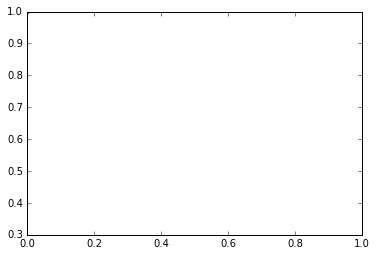

In [157]:
import matplotlib
%matplotlib inline
matplotlib.pyplot.plot(fpr,tpr)

In [137]:
sklearn.metrics.auc(fpr, tpr)

0.99995034427966101

# Model Evaluation

Lets just take random junior add from the Web and run the model to check. "text.txt" is just a random job description.

In [159]:
test = open('text.txt').read()


test_clean = re.sub("[^a-zA-Z]", " ", test)

stop = set(stopwords.words('english'))
stop.update([',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '...', 'Data', 'data', 'scientist', 'Scientist'])

test_word = [w for w in (nltk.word_tokenize(test_clean)) if w.lower() not in stop]


len(test_word)

103

I put into "text.txt" sentences from junior ad (58 words) and part from senior position ad (45 words). Assume data set is balanced

In [160]:
array = []
for i in xrange(0,58): # junior words
    array.append(1)
for i in xrange(58,103): # senior words
    array.append(0)



Let's put them into data frame (column "Fact") of "zeros" and "ones". "0" - not junior, "1" - junior.  Then I ran model and added predictions into column Y_pred:

In [161]:
DF = pd.DataFrame({'Sentences' : pd.Series(test_word),
                   "Fact" : array,
                   })
DF["Y_pred"] = np.where(logreg.predict(tfidf.transform(test_word)), 1, 0)
DF

,Fact,Sentences,Y_pred
0,1,Investigate,1
1,1,problems,1
2,1,identify,1
3,1,patterns,1
4,1,passionate,0
5,1,applying,0
6,1,analytics,0
7,1,real,0
8,1,problems,1
9,1,seeking,0


Let's build confusion matrix:

In [162]:
((DF.Y_pred == 1) & (DF.Fact == 1)).sum() #true positives

40

In [165]:
((DF.Y_pred == 0) & (DF.Fact == 0)).sum() #true negatives

27

In [164]:
conmat = np.array(confusion_matrix(DF.Y_pred, DF.Fact))
conmat

array([[27, 18],
       [18, 40]])

In [144]:
whole_df.junior.value_counts()

0    720
1    382
Name: junior, dtype: int64

In [166]:
(X_train, X_test, Y_train, Y_test) = train_test_split(
  tfidf.fit_transform(DF.Sentences),
  DF['Fact'],
  test_size=0.33
)

As you can see model works on real data but the coefficients are much worse than in original data set.

In [167]:
sklearn.cross_validation.cross_val_score(logreg,
                                         tfidf.fit_transform(DF.Sentences),
                                         DF.Y_pred,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.54545455,  0.63636364,  0.63636364,  0.54545455,  0.54545455,
        0.6       ,  0.6       ,  0.6       ,  0.55555556,  0.55555556])